In [94]:
!nvidia-smi

OSError: [Errno 12] Cannot allocate memory

In [83]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
#Progress bar fix: use callbacks=[Logger.JupyterProgbarLogger()] in model.fit
#verbose=0 is also required
import JupyterProgbarLogger as Logger
from tqdm import tqdm_notebook as tqdm
from kerastuner.tuners import RandomSearch

import sklearn.metrics as metrics

import numpy as np
import random
import math
import matplotlib.pyplot as plt

import h5py

###FIX NUMPY LOAD FOR DICTIONARIES\
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [42]:
BATCH_SIZE=32
DATA_AMOUNT=1000000

In [91]:
def sort_data(data,labels,train_len,val_len,test_len,blocksize=1):
    curBlock = labels[0]
    train_data = np.zeros((train_len,80,80,1))
    val_data = np.zeros((val_len,80,80,1))
    test_data = np.zeros((test_len,80,80,1))
    train_labels = np.full(train_len,-1)
    val_labels = np.full(val_len,-1)
    test_labels = np.full(test_len,-1)
    train_ind = 0
    val_ind = 0
    test_ind = 0
    choices = np.arange(3)
    i=0
    cur_len = 0
    while i < len(data):
        start = i-cur_len
        iter_amt = len(data) if blocksize == 1 else blocksize
        while labels[i]==curBlock and cur_len < iter_amt:
            i+=1
            cur_len+=1
            if i == len(data):
                break
        end = i
        if not i == len(data):
            if labels[i]==curBlock:
                cur_len-=int(blocksize/2)
            else:
                cur_len=0
            curBlock = labels[i]
        if not blocksize == 1 and end-start < blocksize:
            continue
        cur_frames = data[start:end]
        cur_labels = labels[start:end]
        choice=-1
        if choices.size>0:
            choice = np.random.choice(choices)
        else:
            break
        if choice == 0:
            if train_ind + len(cur_frames) >= train_len:
                cur_frames = cur_frames[:train_len-train_ind]
                cur_labels = cur_labels[:train_len-train_ind]
                choices=np.delete(choices,np.argwhere(choices==0))
            train_data[train_ind:train_ind+len(cur_frames)]=cur_frames
            train_labels[train_ind:train_ind+len(cur_frames)]=cur_labels
            train_ind += len(cur_frames)
        elif choice == 1:
            if val_ind + len(cur_frames) >= val_len:
                cur_frames = cur_frames[:val_len-val_ind]
                cur_labels = cur_labels[:val_len-val_ind]
                choices=np.delete(choices,np.argwhere(choices==1))
            val_data[val_ind:val_ind+len(cur_frames)]=cur_frames
            val_labels[val_ind:val_ind+len(cur_frames)]=cur_labels
            val_ind += len(cur_frames)
        elif choice == 2:
            if test_ind + len(cur_frames) >= test_len:
                cur_frames = cur_frames[:test_len-test_ind]
                cur_labels = cur_labels[:test_len-test_ind]
                choices=np.delete(choices,np.argwhere(choices==2))
            test_data[test_ind:test_ind+len(cur_frames)]=cur_frames
            test_labels[test_ind:test_ind+len(cur_frames)]=cur_labels
            test_ind += len(cur_frames)
    return train_data[:train_ind-(train_ind%blocksize)],train_labels[:train_ind-(train_ind%blocksize)],val_data[:val_ind-(val_ind%blocksize)],val_labels[:val_ind-(val_ind%blocksize)],test_data[:test_ind-(test_ind%blocksize)],test_labels[:test_ind-(test_ind%blocksize)]

In [92]:
file_path = "images_raw_doric_round1.h5"
with h5py.File(file_path,'r') as f:
    labels = f['/labels'][:DATA_AMOUNT]
    data = f['/frames/raw'][:DATA_AMOUNT]
data = data[(labels>=0)]
labels = labels[(labels>=0)]
DATA_AMOUNT=len(data)
if len(data.shape) < 4:
    data=data[...,None]
tl = math.floor(DATA_AMOUNT/2)
vl=tsl=math.floor(DATA_AMOUNT/4)
depth=32
train_data,train_labels,val_data,val_labels,test_data,test_labels = sort_data(data,labels,tl,vl,tsl,blocksize=depth)
del data
del labels

In [98]:
def build_model(
                input_shape=(1,80, 80, 1),
                stride_length=(1, 1, 1),
                kernel=(3,3,3),
                kernel_initializer='glorot_uniform',
                activation=layers.Activation('relu'),
                dense_activation=layers.Activation('relu'),
                output_activation=layers.Activation('softmax'),
                batch_momentum=.999,
                dropout_chance=0.2,
                combine=True,
                padding='valid',
                batch_norm=False,
                dropout=False
            ):
    name = "3D CNN"
    nfilters=[32,64,128]
    inputs = layers.Input(shape=input_shape)
    x = inputs


    conv_parameters = {
        'padding': padding,
        'strides': stride_length,
        'kernel_initializer': kernel_initializer
    }


    # encode net
    for filters in nfilters:
        x = layers.Conv3D(filters, kernel, **conv_parameters)(x)
        if batch_norm:
            x = layers.BatchNormalization(momentum=batch_momentum)(x)
        elif dropout:
            x = layers.Dropout(dropout_chance)(x)
        #x = activation(x)
        x = layers.MaxPooling3D((2, 2, 2), padding=padding)(x)
    #x = layers.Conv2D(1, (1, 1))(x)
    #x = activation(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(46)(x)
    output = output_activation(x)


    model = keras.models.Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=1e-3,
            momentum=0.9,
            nesterov=True,
            decay=1e-6
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model,name

In [99]:
if not depth == 1:
    model,name = build_model(input_shape=(depth,80,80,1))
    if(len(train_data.shape)<5):
        train_data=np.reshape(train_data,(int(len(train_data)/depth),depth,80,80,1))
        val_data=np.reshape(val_data,(int(len(val_data)/depth),depth,80,80,1))
        test_data=np.reshape(test_data,(int(len(test_data)/depth),depth,80,80,1))
        train_labels=train_labels[::depth]
        val_labels=val_labels[::depth]
        test_labels=test_labels[::depth]
else:
    model,name = build_model()
print(model.summary())

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 80, 80, 1)]   0         
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 30, 78, 78, 32)    896       
_________________________________________________________________
max_pooling3d_51 (MaxPooling (None, 15, 39, 39, 32)    0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 13, 37, 37, 64)    55360     
_________________________________________________________________
max_pooling3d_52 (MaxPooling (None, 6, 18, 18, 64)     0         
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 4, 16, 16, 128)    221312    
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 2, 8, 8, 128)      0  

In [100]:
history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    verbose=0,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_data,val_labels),
                    callbacks=[Logger.JupyterProgbarLogger()]
                   )

Epoch 1/10


Metrics: loss: 2.9100 - accuracy: 0.1991 - val_loss: 2.7204 - val_accuracy: 0.2775
Epoch 2/10


Metrics: loss: 2.4486 - accuracy: 0.3419 - val_loss: 2.5705 - val_accuracy: 0.3014
Epoch 3/10


Metrics: loss: 2.1178 - accuracy: 0.4260 - val_loss: 2.6231 - val_accuracy: 0.2626
Epoch 4/10


Metrics: loss: 1.8012 - accuracy: 0.4737 - val_loss: 5.1375 - val_accuracy: 0.0213
Epoch 5/10


Metrics: loss: 1.6581 - accuracy: 0.5051 - val_loss: 2.3660 - val_accuracy: 0.2692
Epoch 6/10


Metrics: loss: 1.3439 - accuracy: 0.5690 - val_loss: 1.3986 - val_accuracy: 0.5825
Epoch 7/10


Metrics: loss: 1.1939 - accuracy: 0.6293 - val_loss: 1.5362 - val_accuracy: 0.4884
Epoch 8/10


Metrics: loss: 1.0761 - accuracy: 0.6505 - val_loss: 2.4465 - val_accuracy: 0.4005
Epoch 9/10


Metrics: loss: 1.0252 - accuracy: 0.6531 - val_loss: 2.0760 - val_accuracy: 0.4040
Epoch 10/10


Metrics: loss: 0.9456 - accuracy: 0.6617 - val_loss: 1.5954 - val_accuracy: 0.5078


In [101]:
def accuracy(predictions, answers):
    accs = np.zeros(len(answers))
    for i in range(0,len(answers)):
        if(predictions[i]==answers[i]):
            accs[i]=1
    return np.mean(accs)

In [102]:
predicts = np.argmax(model.predict(test_data),1)

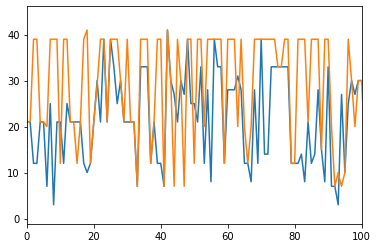

In [103]:
#plt.hist((test_labels,predicts), density=True, histtype='bar', stacked=True, label = ("Data","Predictions"))
#plt.legend()
plt.plot(test_labels)
plt.plot(predicts)
plt.xlim(0,100)
plt.show()

In [104]:
print(accuracy(predicts,test_labels))
print(metrics.f1_score(test_labels,predicts,average=None))

0.507925407925408


/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.         0.19047619 0.         0.54545455 0.         0.39751553
 0.25668449 0.22222222 0.60869565 0.         0.60085837 0.
 0.2962963  0.78518519 0.         0.         0.54221165 0.65156419
 0.26666667 0.13333333 0.4        0.         0.21052632 0.05405405
 0.00985222 0.36       0.65454545 0.21621622 0.66666667 0.72294887
 0.0952381  0.         0.25018182 0.         0.44094488 0.68965517
 0.7444795  0.84210526]


In [ ]:
model_benchmarks = np.load("benchmarks.npy")
model_benchmarks.item()[name]=metrics.f1_score(test_labels,predicts,average=None)
np.save("benchmarks.npy",model_benchmarks)
print(model_benchmarks)

In [ ]:
print(train_data.shape)

In [ ]:
print(test_labels[0:300])

In [ ]:
plt.plot(labels)
ind = 500
plt.xlim(ind,ind+10)
plt.show()

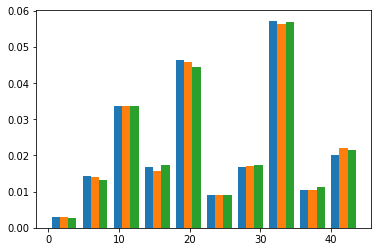

In [111]:
plt.hist((train_labels,val_labels,test_labels),density=True)
#plt.hist(train_labels,46,density=True)
plt.show()